In [1]:
from src.frame import Frame
from src.feature import SDF_Feature
from src.dataset import *
from src.utils import *
# from src.data_gen_utils import *

from os import path
import matplotlib.pyplot as plt

import trimesh

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

# exp_name = 'noPixelAligned_best'
exp_name = 'PIFO_best'
state = torch.load('network/'+exp_name+'.pth.tar')
C = state['config']

trainset = PIFODataset(C['DATA_FILENAME'],
                       num_views=C['NUM_VIEWS'],
                       num_points=C['NUM_POINTS'],
                       num_grasps=C['NUM_GRASPS'],
                       num_hangs=C['NUM_HANGS'],
                       grasp_draw_points=C['GRASP_DRAW_POINTS'],
                       hang_draw_points=C['HANG_DRAW_POINTS'],
                       random_erase=False,
                       on_gpu_memory= (device=="cuda") )
# trainset.show_data(0)
testset = PIFODataset('data/test_batch.hdf5',
                      num_views=C['NUM_VIEWS'],
                      num_points=C['NUM_POINTS'],
                      num_grasps=C['NUM_GRASPS'],
                      num_hangs=C['NUM_HANGS'],
                      grasp_draw_points=C['GRASP_DRAW_POINTS'],
                      hang_draw_points=C['HANG_DRAW_POINTS'],
                      random_erase=False,
                      on_gpu_memory= (device=="cuda") )
warper = RandomImageWarper(img_res=C['IMG_RES'])

# Model
obj = Frame()
obj.build_backbone(pretrained=True, **C)
obj.build_sdf_head(C['SDF_HEAD_HIDDEN'])
obj.build_keypoint_head('grasp', C['GRASP_HEAD_HIDDEN'], C['GRIPPER_POINTS'])
obj.build_keypoint_head('hang', C['HANG_HEAD_HIDDEN'], C['HOOK_POINTS'])
obj.load_state_dict(state['network'])
obj.to(device).eval()
F_sdf = SDF_Feature(obj)

# Visualize SDF

/home/jung-su/miniconda3/envs/torchSource/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


============================= 0 ==============================


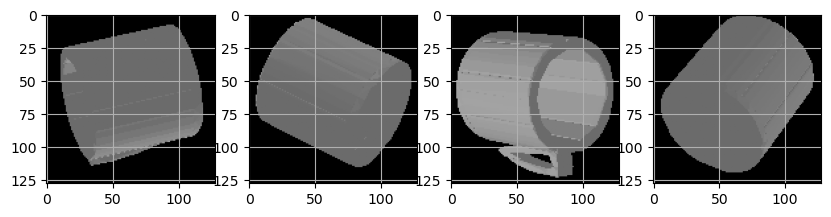

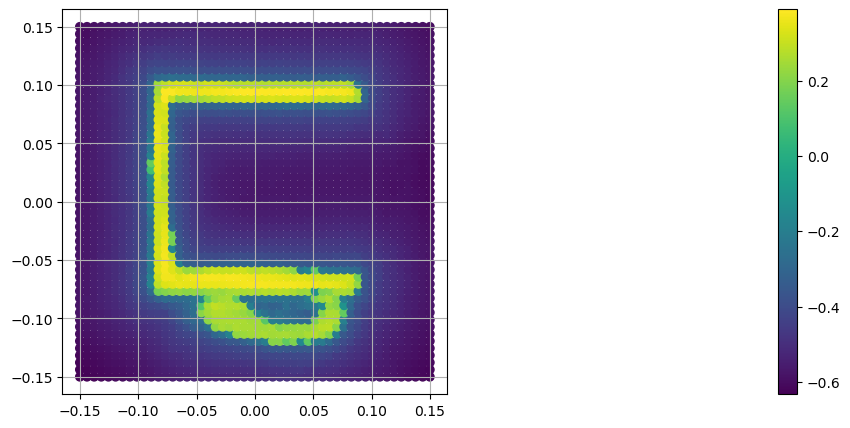

In [3]:
dataset = testset
dataset = trainset

num_grid = 50
lim = .15
dx = torch.linspace(-lim, lim, num_grid, device=device)
grid_x, grid_y = torch.meshgrid(dx, dx)
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

for ind in [0]:
    print('============================= '+str(ind)+' ==============================')
    dataset.show_data(ind, image_only=True)
    data = to_device(dataset[ind], device)
    rgb, projections = warper(data['rgb'].unsqueeze(0), 
                              data['cam_extrinsic'].unsqueeze(0), 
                              data['cam_intrinsic'].unsqueeze(0))
    obj.backbone.encode(rgb, projections)
    
    with torch.no_grad():
        pos = torch.stack([grid_x*0, grid_x, grid_y], axis=1)
        sdf_pred = -F_sdf(pos.unsqueeze(0)).cpu()
        sdf_pred /= C['SDF_SCALE']
#         sdf_pred += .005
        
    plt.figure(figsize=(15,5))
    color = sdf_pred.sign()*sdf_pred.abs().pow(0.2)
    plt.scatter(grid_x.cpu(), grid_y.cpu(), c = color)
    plt.colorbar()
    plt.grid()
    plt.axis([-lim, lim, -lim, lim])
    plt.axis('square')

    plt.show()
    

# Mesh reconstruction via marching cube

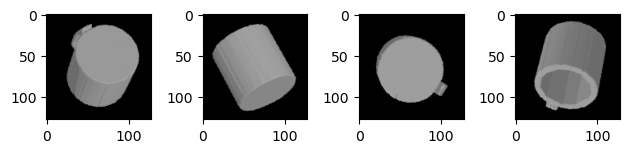

True


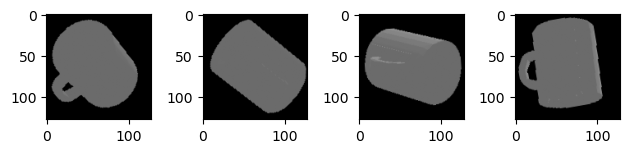

True


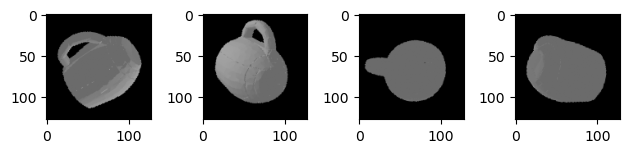

True


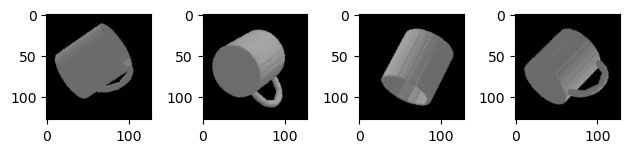

True


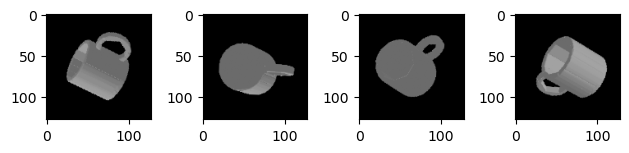

True


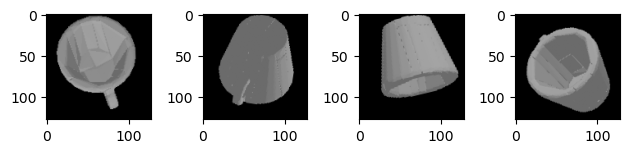

True


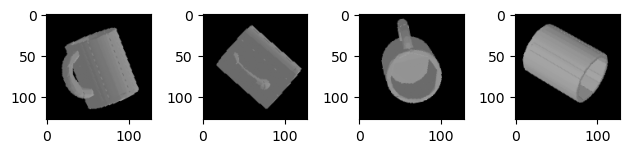

True


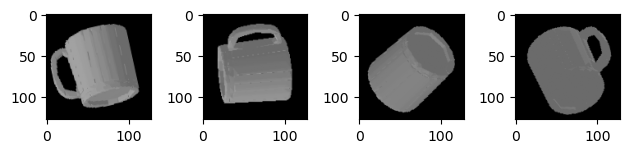

True


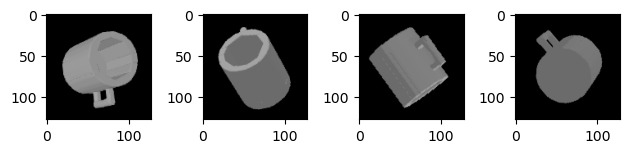

True


In [4]:
dataset = trainset
# dataset = testset
draw_mesh = False
mesh_list,true_mesh_list = [], []
T = np.eye(4)
for j, ind in enumerate(range(0,9)):
    data = to_device(dataset[ind], device)
    rgb, projections = warper(data['rgb'].unsqueeze(0), 
                              data['cam_extrinsic'].unsqueeze(0), 
                              data['cam_intrinsic'].unsqueeze(0))
    
    vertices, faces, normals = obj.extract_mesh(rgb,
                                                projections, 
                                                scale=.2, 
                                                delta=0.00,
                                                sdf_scale=C['SDF_SCALE'],
                                                draw=draw_mesh)
    if not draw_mesh:
        render_images = rgb.squeeze(0).cpu()
        num_views = render_images.shape[0]
        fig = plt.figure()
        for i in range(num_views):
            ax = plt.subplot(1,num_views,i+1)
            ax.imshow(render_images[i,...].permute(1,2,0))
        plt.tight_layout()
        plt.show()
        T[0,3] = .4 * (j//3)
        T[1,3] = .4 * (j%3)
        T[2,3] = 0.
        mesh = trimesh.Trimesh(vertices=vertices, 
                               faces=faces).apply_transform(T)
        print(mesh.is_watertight)
        mesh.visual.vertex_colors = [.5, .5, 1.]
        mesh_list.append(mesh)
    
        T[2,3] = .3
        true_mesh = trimesh.load('data/meshes_coll/'+data['filenames'].decode()).apply_transform(T)
        true_mesh.visual.vertex_colors = [1., .5, .5]
        true_mesh_list.append(true_mesh)

trimesh.Scene(mesh_list+true_mesh_list).show()

# PCA on image features

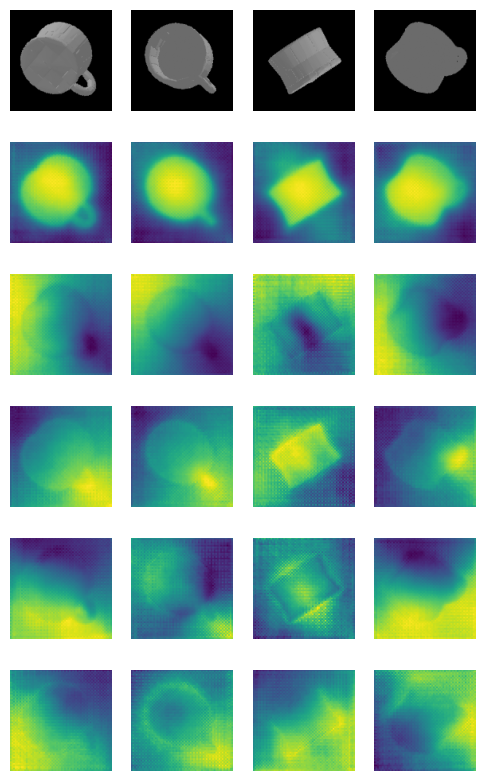

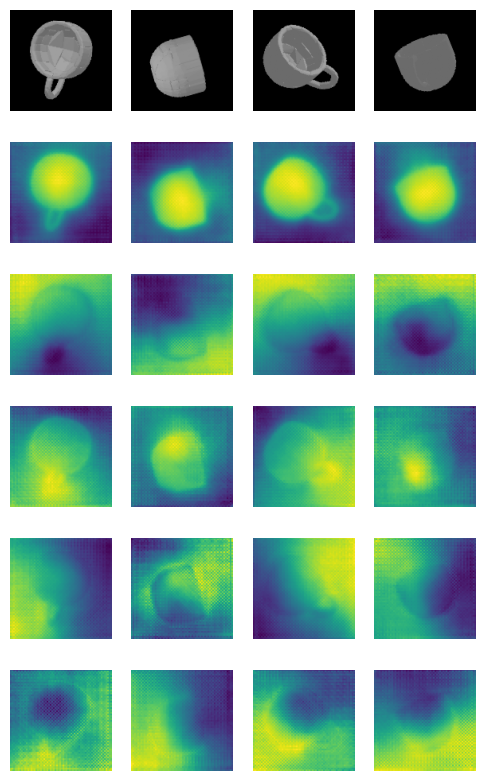

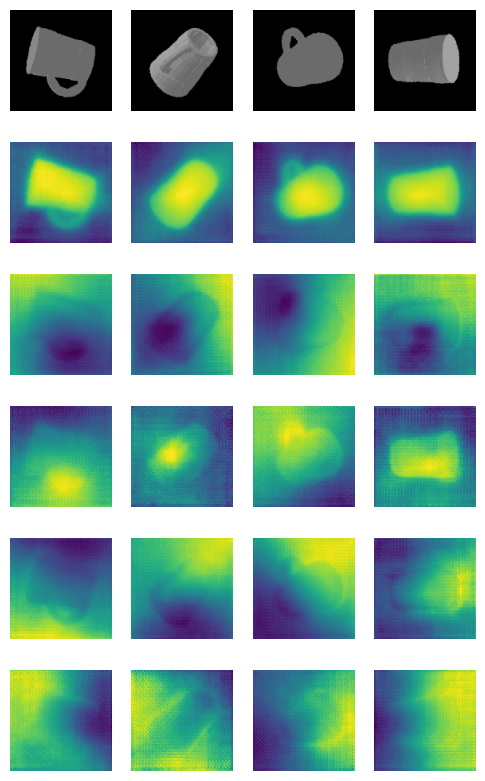

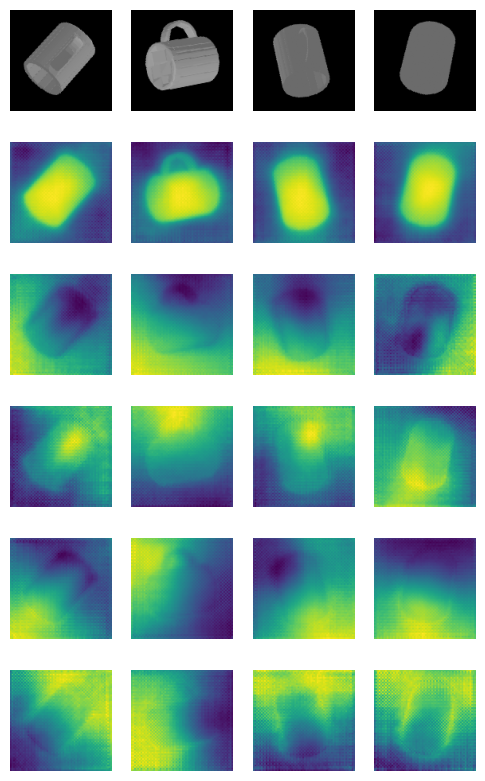

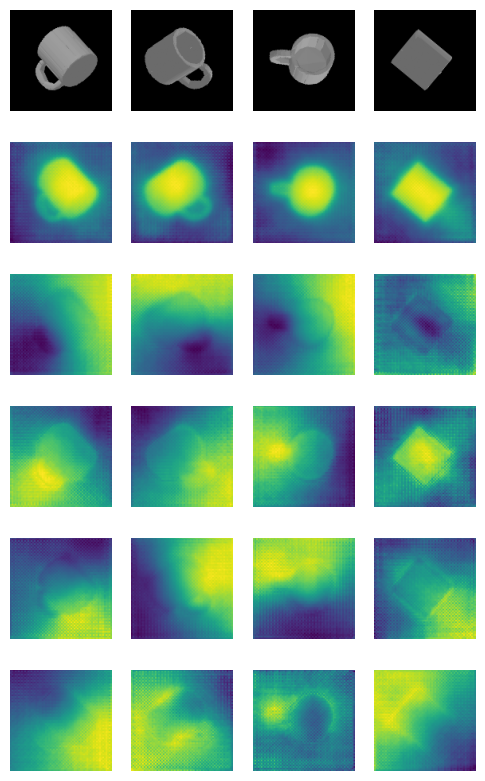

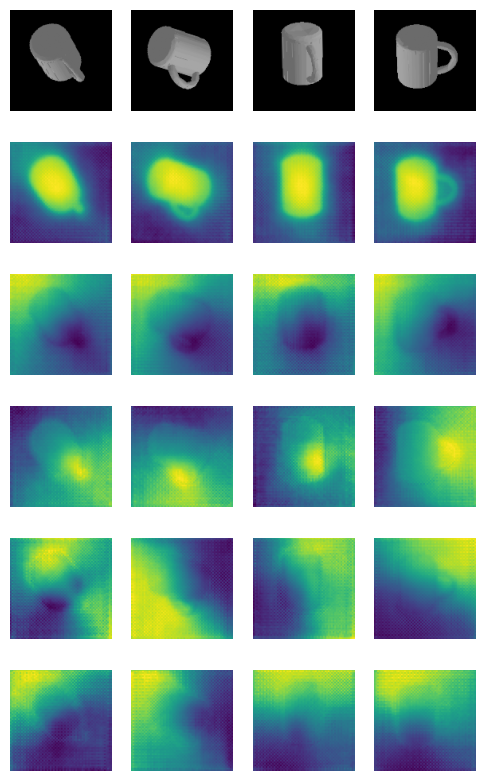

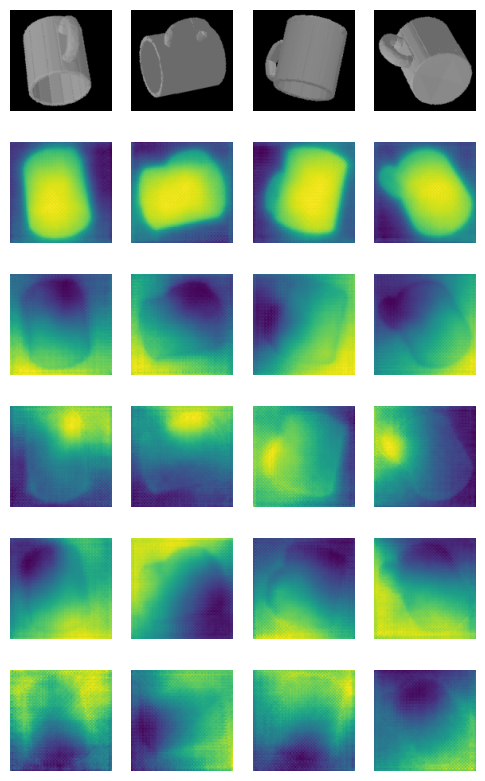

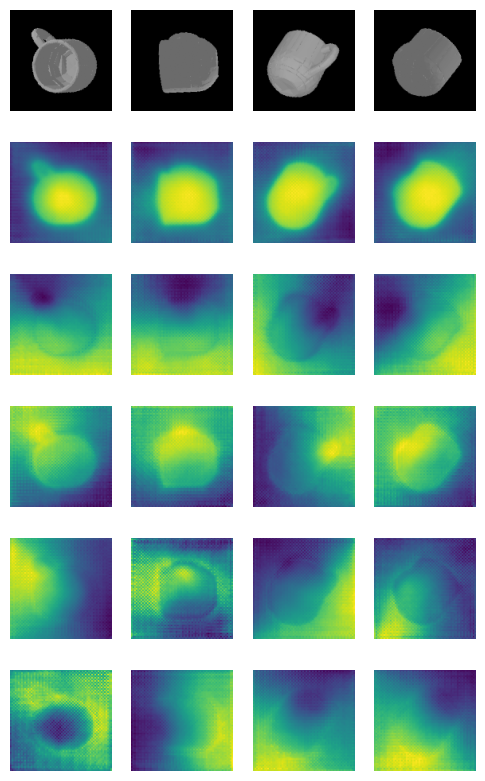

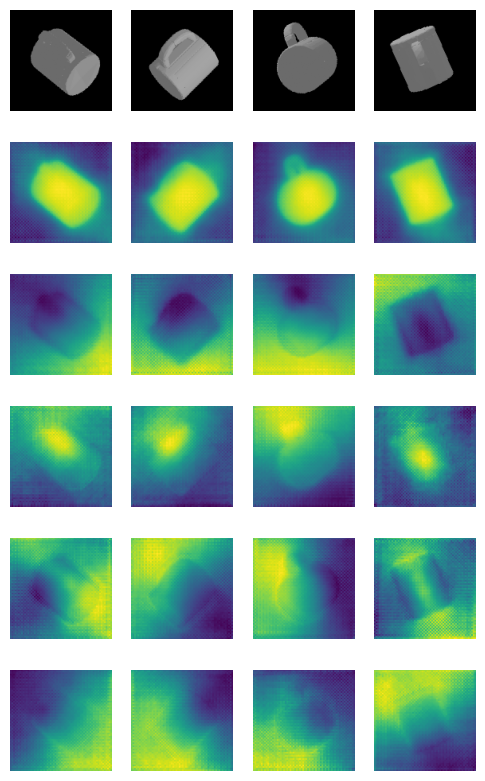

In [5]:
# dataset = testset
dataset = trainset

rgb_list, extrinsic_list, intrinsic_list = [], [], []
for ind in range(10,19):
    data = to_device(dataset[ind], device)
    rgb_list.append(data['rgb'])
    extrinsic_list.append(data['cam_extrinsic'])
    intrinsic_list.append(data['cam_intrinsic'])
    
rgb, projections = warper(torch.stack(rgb_list, dim=0), 
                          torch.stack(extrinsic_list, dim=0), 
                          torch.stack(intrinsic_list, dim=0))
with torch.no_grad():
    obj.backbone.encode(rgb, projections)

features = obj.backbone.img_features.permute(0,2,3,1).contiguous()
feat_dim = features.shape[-1]
U, S, V = torch.pca_lowrank(features.view(-1,feat_dim))
num_colors = 5
colors = torch.matmul(features.view(-1,feat_dim), V[:, :num_colors]) # (B*num_views*64*64, 3)

colors -= colors.min(dim=0,keepdim=True)[0]
colors /= colors.max(dim=0,keepdim=True)[0]

# colors -= colors.mean(dim=0,keepdim=True)
# colors /= 2.*colors.std(dim=0,keepdim=True)
# colors += 0.5
# colors.clamp_(0,1)

num_views = obj.backbone.num_views
colors = colors.view(-1, num_views, 64, 64, num_colors).cpu()

for b in range(colors.shape[0]):
    plt.figure(figsize=(6,10))
    for n in range(num_views):
        img = rgb[b,n].permute(1,2,0).cpu()
        
        plt.subplot(1+num_colors, num_views, n+1)
        plt.imshow(img)
        plt.axis('off')
        
        for c in range(num_colors):
            plt.subplot(1+num_colors, num_views, (c+1)*num_views+n+1)
            plt.imshow(colors[b,n,:,:,c])
            plt.axis('off')
#     plt.savefig("feat"+str(b)+".pdf", bbox_inches='tight')
    plt.show()

# PCA on surface representation vectors

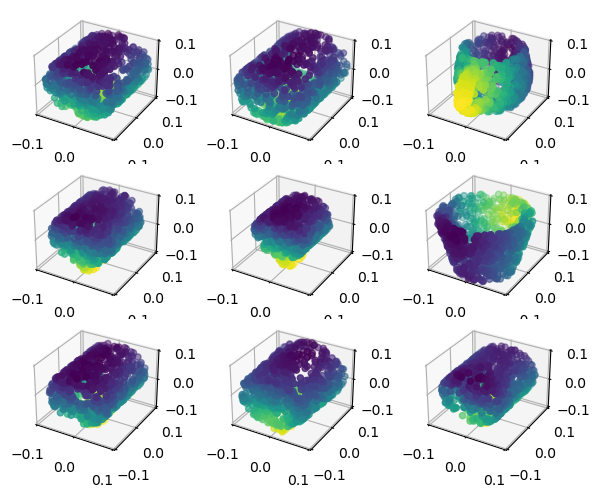

In [6]:
dataset = trainset
# dataset = testset

inds = list(range(0,9))
# inds = [20]*9
B, N = len(inds), 1000

points, img, projection = [], [], []
for ind in inds:
    data = dataset[ind]
    
    mesh_filename = path.join('data/meshes', data['filenames'].decode())
    object_trimesh = trimesh.load(mesh_filename)
    points.append(torch.Tensor(object_trimesh.sample(N)).to(device))
    
    rgb, projections = warper(data['rgb'].unsqueeze(0), 
                              data['cam_extrinsic'].unsqueeze(0), 
                              data['cam_intrinsic'].unsqueeze(0))
    img.append(rgb.squeeze(0))
    projection.append(projections.squeeze(0))
    
points = torch.stack(points, dim=0)
img = torch.stack(img, dim=0)
projection = torch.stack(projection, dim=0)
    
with torch.no_grad():
    features = obj.backbone(points, img, projection).mean(dim=1)

    
feat_dim = features.shape[-1]
U, S, V = torch.pca_lowrank(features.view(-1,feat_dim))
num_color = 1
start = 0
colors = torch.matmul(features.view(-1,feat_dim), V[:, start:start+num_color])

colors -= colors.min(dim=0,keepdim=True)[0]
colors /= colors.max(dim=0,keepdim=True)[0]

colors = colors.view(B, N, num_color).detach().cpu().numpy()
fig = plt.figure()
for i, point in enumerate(points):
    ax = plt.subplot(B//3, 3, i+1, projection='3d')
    point = point.cpu().numpy()
    if num_color == 1:
        ax.scatter(point[:,0],point[:,1],point[:,2], c=colors[i])
    else:
        ax.scatter(point[:,0],point[:,1],point[:,2], color=colors[i])
        
    ax.set_xlim([-.1,.1])
    ax.set_ylim([-.1,.1])
    ax.set_zlim([-.1,.1])
ax.grid()
plt.tight_layout()
plt.show()